<a href="https://colab.research.google.com/github/scheung97/EECE5639_ComputerVision/blob/main/p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 # Northeastern University
# EECE5639 Computer Vision

# Spenser Cheung & Tim Liming

# Project 2

import cv2 
import numpy as np 
import os
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep
from scipy import ndimage
from scipy import signal

from google.colab.patches import cv2_imshow
from google.colab import drive


In [ ]:
!python3 --version

In [2]:
# Mount Google Drive in Google Colab

# Public 'DanaOffice' folder link: 
# https://drive.google.com/drive/folders/1WUWYblxSid4YkRJawACK7tNizW79Zk6h?usp=sharing

# Public 'DanaHallWay1' folder link: 
# https://drive.google.com/drive/folders/1Y-nP4B0Usws3yPL4f0T-pGWNcd-o1qGs?usp=sharing

drive.mount('/content/gdrive', force_remount=True)

office_path = "/content/gdrive/MyDrive/EECE5639_P2_DanaOffice"
hallway_path = "/content/gdrive/MyDrive/EECE5639_P2_DanaHallWay1"

Mounted at /content/gdrive


In [3]:
# i. Read in two images.

# Office
office_files = [filename for filename in sorted(os.listdir(office_path)) if os.path.isfile(os.path.join(office_path, filename))]

office_images = []    
for i in range(0, len(office_files)): 
    img = cv2.imread(os.path.join(office_path, office_files[i]))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
    office_images.append(gray_img)

office_images = np.array(office_images)
print(office_images.shape)


(10, 340, 512)


In [4]:
# i. Read in two images.

# Hallway
hallway_files = [filename for filename in sorted(os.listdir(hallway_path)) if os.path.isfile(os.path.join(hallway_path, filename))]

hallway_images = []
for i in range(0, len(hallway_files)): 
    img = cv2.imread(os.path.join(hallway_path, hallway_files[i]))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
    hallway_images.append(gray_img)

hallway_images = np.array(hallway_images)
print(hallway_images.shape)


(3, 340, 512)


Reduced Images:


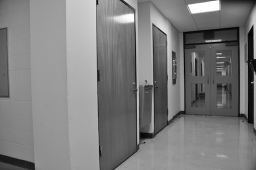

----------------------------------


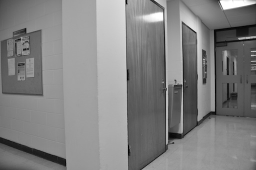

----------------------------------


In [29]:
# i. Read in two images. (Note: if the images are large, you may want to reduce
# their size to keep running time reasonable! Document in your report the scale
# factor you used.)

use_hall = True
#use_hall = False
if use_hall:
    img1, img2 = np.random.default_rng().choice(hallway_images, 2, replace=False)
else:
    img1, img2 = np.random.default_rng().choice(office_images, 2, replace=False)

#print('Original Images:')
#cv2_imshow(img1)
#print('--------------------------------------------------------------')
#cv2_imshow(img2)
#print('--------------------------------------------------------------')

scale = 0.5
r_img1 = cv2.resize(img1, (0,0), fx=scale, fy=scale)
r_img2 = cv2.resize(img2, (0,0), fx=scale, fy=scale)

print('Reduced Images:')
cv2_imshow(r_img1)
print('----------------------------------')
cv2_imshow(r_img2)
print('----------------------------------')


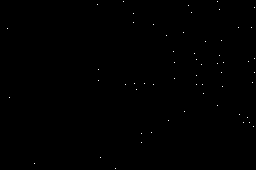

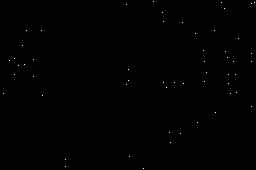

Harris Corners:


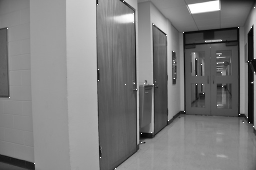

----------------------------------


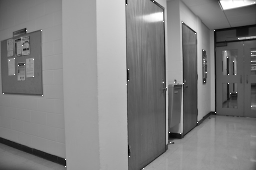

----------------------------------


In [30]:
# ii. Apply Harris corner detector to both images: compute Harris R function 
# over the image, and then do non-maximum suppression to get a sparse set of 
# corner features.

# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
# https://stackoverflow.com/a/56802012

# https://stackoverflow.com/questions/6931362/non-maximum-suppression-in-opencv
# https://fahmifahim.com/2010/10/22/opencv-corner-detection/


def harris1(img):
    # Compute the Image Gradient
    Ix = cv2.Sobel(img, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
    Iy = cv2.Sobel(img, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)

    # Compute products of derivatives at each pixel
    I2x = Ix * Ix
    I2y = Iy * Iy
    Ixy = Ix * Iy

    # Compute the sums of the products at each pixel using a window averaging:
    gauss_window = signal.windows.gaussian(3 * 3, std=1, sym=True)
    gauss_window = np.reshape(gauss_window, (3, 3))

    S2x = signal.convolve2d(gauss_window, I2x) # Gs' * I2x
    S2y = signal.convolve2d(gauss_window, I2y) # Gs’ * I2y 
    Sxy = signal.convolve2d(gauss_window, Ixy) # Gs’ * Ixy

    # Define the Matrix at each pixel
    M_top = np.hstack((S2x, Sxy))
    M_bot = np.hstack((Sxy, S2y))
    M = np.vstack((M_top, M_bot)) # [S2x Sxy ; Sxy S2y]
    #print(M)

    # Compute the response
    k = 0.04
    det_M = (S2x * S2y) - (Sxy * Sxy)
    trace_M = (S2x + S2y)
    R = det_M - k * (trace_M)**2
    print('R:')
    #print(R)
    cv2_imshow(R)

    # Threshold R
    ret, R = cv2.threshold(R, 0.01*R.max(), 255, 0)
    print('Thresholded R:')
    #print(R)
    cv2_imshow(R)

    # Compute Nonmax suppression
    image = np.pad(R, ((1, 1), (1, 1)))
    local_max = np.zeros_like(image)

    for i in range(1,image.shape[0]-1):
        for j in range(1,image.shape[1]-1):
            window = image[i-1:i+2, j-1:j+2]
            if image[i,j] == np.amax(window):
                local_max[i,j] = image[i,j]

    # remove padding
    corners = local_max[2:-2, 2:-2]

    return corners, (corners + img)


def harris2(img):
    # find Harris corners
    src = np.float32(img)
    dst = cv2.cornerHarris(src, blockSize=2, ksize=3, k=0.05)

    # result is dilated for marking the corners
    dst = cv2.dilate(dst, None)

    # Threshold for an optimal value
    ret, dst = cv2.threshold(dst, 0.01*dst.max(), 255, 0)
    dst = np.uint8(dst)

    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(img, np.float32(centroids), (5,5), (-1,-1), criteria)

    # Now draw them
    res = np.hstack((centroids, corners))
    res = np.int0(res)
    img[res[:,1],res[:,0]] = 255

    corners = np.zeros_like(img)
    corners[res[:,1],res[:,0]] = 255
    return corners, img

# -----------------------------------------

#corners1, h_img1 = harris1(r_img1)
#corners2, h_img2 = harris1(r_img2)
#cv2_imshow(corners1)
#cv2_imshow(corners2)

corners1, h_img1 = harris2(r_img1)
corners2, h_img2 = harris2(r_img2)
cv2_imshow(corners1)
cv2_imshow(corners2)


print('Harris Corners:')
cv2_imshow(h_img1)
print('----------------------------------')
cv2_imshow(h_img2)
print('----------------------------------')


In [32]:
# iii. Find correspondences between the two images: given two set of corners 
# from the two images, compute normalized cross correlation (NCC) of image 
# patches centered at each corner. (Note that this will be O(n2) process.) 
# Choose potential corner matches by finding pair of corners (one from each 
# image) such that they have the highest NCC value. You may also set a 
# threshold to keep only matches that have a large NCC score.

def corner_coords(corners):
    # get corner locations
    idx = np.where(corners > 0)
    idx = np.array(idx).T
    return idx


coords1 = corner_coords(corners1)
coords2 = corner_coords(corners2)

[[  1 123]
 [  1 217]
 [  4  97]
 [  5 188]
 [  7 254]
 [  9 219]
 [ 12 191]
 [ 13 133]
 [ 22 133]
 [ 24 153]
 [ 27 238]
 [ 27 251]
 [ 28   7]
 [ 32 183]
 [ 35 166]
 [ 40 221]
 [ 41 205]
 [ 51 173]
 [ 53 194]
 [ 55 219]
 [ 58 254]
 [ 59 196]
 [ 61 248]
 [ 62 174]
 [ 62 223]
 [ 63 217]
 [ 64 201]
 [ 69  98]
 [ 72 221]
 [ 72 254]
 [ 75 196]
 [ 78 174]
 [ 80  98]
 [ 82 252]
 [ 83 134]
 [ 83 144]
 [ 84 125]
 [ 84 153]
 [ 84 196]
 [ 84 202]
 [ 86 222]
 [ 89 136]
 [ 93 203]
 [ 97   9]
 [105 217]
 [111 184]
 [114 239]
 [117 247]
 [120 168]
 [122 243]
 [122 249]
 [126 253]
 [132 151]
 [133 141]
 [142 141]
 [157 100]
 [163  34]
 [168 115]]
[[  1 153]
 [  2 221]
 [  2 254]
 [  3 251]
 [  4 126]
 [  8 224]
 [ 12 162]
 [ 21 163]
 [ 22 182]
 [ 30  26]
 [ 30  41]
 [ 30 214]
 [ 33 195]
 [ 38 238]
 [ 45  22]
 [ 50 203]
 [ 51 225]
 [ 53 251]
 [ 57 227]
 [ 58  14]
 [ 59  33]
 [ 60   9]
 [ 61 204]
 [ 61 233]
 [ 61 251]
 [ 64  24]
 [ 65  18]
 [ 69 128]
 [ 72 206]
 [ 74  14]
 [ 74 228]
 [ 74 235]
 [ 76  33